In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import models

In [3]:
P_param = 6
K_param = 4

### Data

In [4]:
train_dict, train_files = data.get_data('train')

preprocess True
keypoints None
0.961331129074


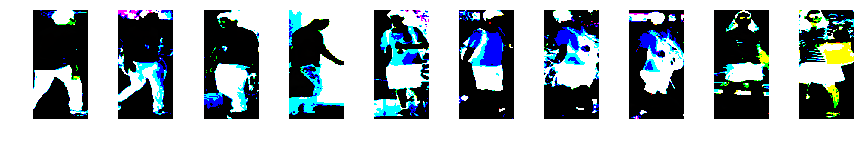

In [5]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                                     shape=(256,128), crop=False, flip=False, rect=False).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

# plt.figure(figsize=(15,2))
# for i in range(10):
#     plt.subplot(1,10,i+1)
#     plt.imshow(batch[2][i].astype(np.uint8))
#     plt.axis('off')
# plt.show()

# import cv2
# plt.figure(figsize=(15,2))
# for i in range(10):
#     plt.subplot(1,10,i+1)
#     plt.imshow(cv2.resize((255 * batch[0]['input_cam'][i]).astype(np.uint8), (8,16)), cmap=plt.cm.gray)
#     plt.axis('off')
# plt.show()

### Train Network

In [6]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

In [7]:
file_root = 'densenet_triplet_P6K4_random_weights'

if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [8]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

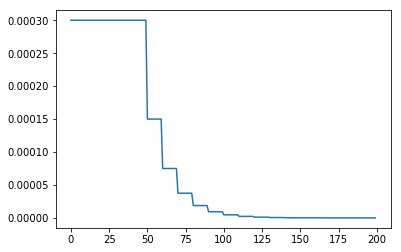

In [9]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [10]:
trinet = models.trinet(P_param, K_param, weights=None)

In [11]:
trinet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [12]:
model_json = trinet.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [13]:
train_score = {}
history = History()
# print_epoch = LearningRateTracker()

for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=preprocess,
                                                     shape=input_shape, crop=False, flip=False, rect=False), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[history])
    
    file_name = file_root + '_' + str(iterations) + '.npy'
    np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), trinet.get_weights())
    
    train_score[iterations] = evaluation.get_score(trinet, hist=history, preprocess=preprocess, 
                                                   shape=input_shape)
    print 'train' , iterations, train_score[iterations]['rank']

preprocess Epoch 1/10True

keypoints None
100/100 [==============================] - 93s - loss: 421.9273    
Epoch 2/10
100/100 [==============================] - 85s - loss: 213.3887    
Epoch 3/10
100/100 [==============================] - 85s - loss: 147.7583    
Epoch 4/10
100/100 [==============================] - 85s - loss: 125.7756    
Epoch 5/10
100/100 [==============================] - 85s - loss: 114.5612    
Epoch 6/10
100/100 [==============================] - 85s - loss: 122.0405    
Epoch 7/10
100/100 [==============================] - 85s - loss: 113.2933    
Epoch 8/10
100/100 [==============================] - 85s - loss: 105.5755    
Epoch 9/10
100/100 [==============================] - 86s - loss: 97.5030    
Epoch 10/10
100/100 [==============================] - 85s - loss: 97.1275    
1000 21.0080330372
2000 41.0361359119
3000 61.0476469994
4000 81.0772550106
5000 101.103511095
6000 121.140505075
7000 141.147326946
8000 161.159311056
9000 181.396883011
10000 201

KeyboardInterrupt: 

In [16]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)

### Evaluation

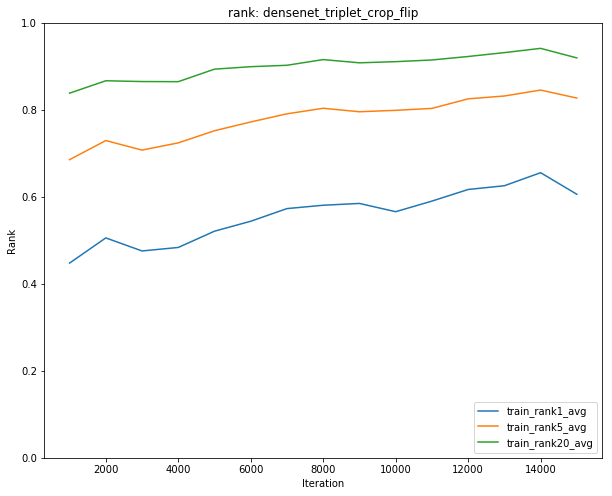

iterations 14000
best_train {1: 0.6555819477434679, 20: 0.9415083135391924, 5: 0.84560570071258911}


In [17]:
evaluation.plot_rank('densenet_triplet_crop_flip', ylim_0=0.0)

In [ ]:
evaluation.plot_rank('densenet_triplet_front', ylim_0=0.0)

In [6]:
trinet = models.trinet(P_param=1, K_param=1, weights=None)
for it in range(1000,16000,1000):
    file_name = file_root + '_' + str(it) + '.npy'
    weights = '/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name)
    trinet.set_weights(np.load(weights))
    
    s = evaluation.get_score(trinet, hist=None, preprocess=preprocess, shape=input_shape)
    print s

1000 20.6567790508
2000 40.3810880184
3000 60.1081409454
4000 79.8409190178
5000 99.5860021114
6000 119.309909105
7000 139.06430006
8000 158.844535112
9000 178.580595016
10000 198.323889971
11000 218.097166061
12000 237.868762016
13000 257.616858006
14000 277.36519599
15000 297.230230093
16000 317.363604069
17000 337.128518105
18000 356.889723063
19000 376.764276028
1000 19.7827119827
2000 39.5765969753
3000 59.3667690754
{'mAP': 0.26029655450827976, 'rank': [0.44625890736342044, 0.6992280285035629, 0.8637173396674585], 'loss': []}
1000 19.797358036
2000 39.6015231609
3000 59.3723721504
4000 79.3295211792
5000 99.1468629837
6000 118.966921091
7000 138.782015085
8000 158.665331125
9000 178.755012989
10000 198.983062983
11000 218.800007105
12000 239.069981098
13000 259.139139175
14000 279.035259962
15000 298.800225019
16000 318.571994066
17000 338.33564806
18000 358.112529039
19000 377.896874189
1000 19.7698051929
2000 39.5428221226
3000 59.3087170124
{'mAP': 0.28399130510450515, 'rank':